In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from transformers import *

In [2]:
import pandas as pd
rootpath='/home/mal/Documents/simra/Task1/'
d1=pd.read_csv(rootpath+'TRAIN.csv')
d2=pd.read_csv(rootpath+'VALIDATION.csv')
d3=pd.read_csv(rootpath+'TEST.csv')
df = pd.concat([d1, d2], ignore_index=True)
df_new=df.dropna()

In [3]:
df_new.drop(df.columns[[0]], axis = 1, inplace = True)
d3.drop(d3.columns[[0]], axis = 1, inplace = True)

/home/mal/Downloads/yes/envs/tensorflow/lib/python3.7/site-packages/pandas/core/frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [4]:
df_new['idx']=df_new.index
d3['idx'] = d3.index

/home/mal/Downloads/yes/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [5]:
df_new=df_new.rename(columns={'Labels': "label", 'Text': "sentence", 'idx': "idx"})
d3=d3.rename(columns={'Labels': "label", 'Text': "sentence", 'idx': "idx"})

In [6]:
d3

,label,sentence,idx
0,0,Low - profile information - stealing Trojan is...,0
1,0,Symantec has uncovered an elusive Trojan used ...,1
2,0,Seaduke ( detected by Symantec as Trojan . Sea...,2
3,0,Seaduke has been used in attacks against a num...,3
4,0,The malware hides behind numerous layers of en...,4
...,...,...,...
613,1,This stealth might be its most important attri...,613
614,0,"As we will see , identifying web shells can be...",614
615,0,"In our next post , we will discuss techniques ...",615
616,0,Stay tuned for Parts 2 - 4 as we cover File St...,616


In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


#from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
#from pytorch_transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
#% matplotlib inline

Using TensorFlow backend.


In [8]:
# Create sentence and label lists
sentences = df_new.sentence.values

In [9]:
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = df_new.label.values


In [10]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


Tokenize the first sentence:
['▁in', '▁late', '▁', 'dec', 'ember', '▁2011', '▁', ',', '▁crowd', 'strike', '▁', ',', '▁in', 'c', '.', '▁received', '▁three', '▁binary', '▁executable', '▁files', '▁that', '▁were', '▁suspected', '▁of', '▁having', '▁been', '▁involved', '▁in', '▁a', '▁so', 'ph', 'istic', 'ted', '▁attack', '▁against', '▁a', '▁large', '▁fortune', '▁500', '▁company', '▁', '.', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


In [11]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
MAX_LEN = 128

In [12]:
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [13]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [14]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)


In [15]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [16]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [17]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [18]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
model.cuda()


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [19]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]




In [20]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)


In [21]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)


'TITAN RTX'

In [24]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))



Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.32258884223631107



Epoch:  10%|█         | 1/10 [02:03<18:34, 123.81s/it]

Validation Accuracy: 0.8479950365726228
Train loss: 0.24530556724985708



Epoch:  20%|██        | 2/10 [04:07<16:30, 123.87s/it]

Validation Accuracy: 0.8537748171368861
Train loss: 0.1707240431003172



Epoch:  30%|███       | 3/10 [06:08<14:20, 122.86s/it]

Validation Accuracy: 0.8591627481713688
Train loss: 0.10232856737550448



Epoch:  40%|████      | 4/10 [08:09<12:13, 122.30s/it]

Validation Accuracy: 0.8547217868338558
Train loss: 0.06683908140198705



Epoch:  50%|█████     | 5/10 [10:11<10:12, 122.40s/it]

Validation Accuracy: 0.8568116509926854
Train loss: 0.05535837183580608



Epoch:  60%|██████    | 6/10 [12:17<08:13, 123.36s/it]

Validation Accuracy: 0.8549177115987461
Train loss: 0.042986591809863424



Epoch:  70%|███████   | 7/10 [14:16<06:06, 122.06s/it]

Validation Accuracy: 0.8679793625914316
Train loss: 0.026405744063447707



Epoch:  80%|████████  | 8/10 [16:17<04:03, 121.72s/it]

Validation Accuracy: 0.8374804075235109
Train loss: 0.024472723362614978



Epoch:  90%|█████████ | 9/10 [18:18<02:01, 121.52s/it]

Validation Accuracy: 0.8498889759665622
Train loss: 0.023450275096488563



Epoch: 100%|██████████| 10/10 [20:19<00:00, 121.99s/it]

Validation Accuracy: 0.8620036572622779


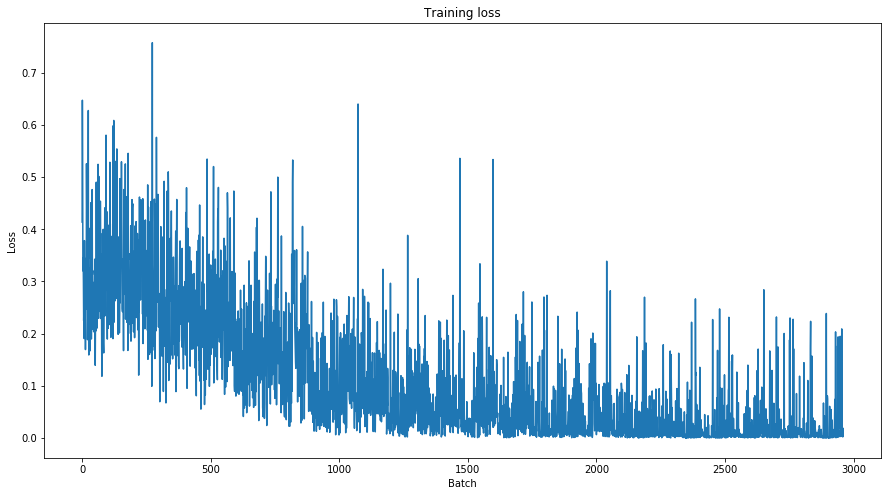

In [25]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()


In [26]:
# Create sentence and label lists
sentences = d3.sentence.values

# We need to add special tokens at the beginning and end of each sentence for XLNet to work properly
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = d3.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [27]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)


In [28]:
true_labels

[array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 1]),
 array([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 

In [29]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)


/home/mal/Downloads/yes/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [30]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [31]:
len(flat_true_labels)

618

In [32]:
#len(flat_predictions)
pred=flat_predictions.tolist()

In [33]:
len(pred)

618

In [34]:
matthews_corrcoef(flat_true_labels, flat_predictions)


0.3566688588182485

In [35]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(flat_true_labels, pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.93      0.80      0.86       528
     class 1       0.36      0.64      0.46        90

    accuracy                           0.78       618
   macro avg       0.64      0.72      0.66       618
weighted avg       0.85      0.78      0.80       618



In [7]:
train_df = tf.data.Dataset.from_tensor_slices(dict(df_new))
test_df = tf.data.Dataset.from_tensor_slices(dict(d3))

for feature_batch in train_df.take(1):
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

  'label'             : 0
  'sentence'          : b'In late December 2011 , CrowdStrike , Inc. received three binary executable files that were suspected of having been involved in a sophisticted attack against a large Fortune 500 company .'
  'idx'               : 0


In [8]:
train_df

<TensorSliceDataset shapes: {label: (), sentence: (), idx: ()}, types: {label: tf.int32, sentence: tf.string, idx: tf.int32}>

In [10]:
# load a csv
#CSV_PATH = rootpath+'TRAIN.csv'
#dataset = tf.contrib.data.make_csv_dataset(CSV_PATH, batch_size=32)
#iter = dataset.make_one_shot_iterator()
#next = iter.get_next()
#print(next) # next is a dict with key=columns names and value=column data

In [11]:
#inputs, labels = next['text'], next['sentiment']

#with  tf.Session() as sess:
#    print(sess.run([inputs,labels]))

In [16]:
# Load dataset, tokenizer, model from pretrained model/vocabulary
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

100%|██████████| 798011/798011 [00:02<00:00, 342914.44B/s]


In [17]:
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased')

100%|██████████| 467042463/467042463 [04:39<00:00, 1671802.52B/s]


In [18]:
#data = tensorflow_datasets.load('glue/sst2')

In [19]:
train_dataset = glue_convert_examples_to_features(train_df, tokenizer, max_length=128, task='sst-2')

In [20]:
test_dataset = glue_convert_examples_to_features(test_df, tokenizer, max_length=128, task='sst-2')

In [21]:
train_dataset = train_dataset.shuffle(100).batch(32).repeat(2)
valid_dataset = test_dataset.batch(64)

In [22]:
# Prepare dataset for GLUE as a tf.data.Dataset instance
#train_dataset = glue_convert_examples_to_features(train_df, tokenizer, max_length=128, task='mrpc')
#valid_dataset = glue_convert_examples_to_features(data['validation'], tokenizer, max_length=128, task='mrpc')
#train_dataset = train_dataset.shuffle(100).batch(32).repeat(2)
#valid_dataset = valid_dataset.batch(64)

In [26]:
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(input_ids, labels=labels)
loss, logits = outputs[:2]

In [27]:
loss

tensor(0.4783, grad_fn=<NllLossBackward>)

In [25]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy(['accuracy','f1-score'])
#model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train and evaluate using tf.keras.Model.fit()
history = model.fit(train_dataset, epochs=5, steps_per_epoch=115,
                    validation_data=valid_dataset, validation_steps=7)

AttributeError: 'XLNetForSequenceClassification' object has no attribute 'fit'

In [24]:
# Load the TensorFlow model in PyTorch for inspection
model.save_pretrained('/home/mal/Documents/simra/Task1/xlnet')

In [36]:
sentences

['Low - profile information - stealing Trojan is used only against high- value targets . [SEP] [CLS]',
 'Symantec has uncovered an elusive Trojan used by the cyberespionage group behind the € œDuke € \u200b family of malware . [SEP] [CLS]',
 'Seaduke ( detected by Symantec as Trojan . Seaduke ) is a low - profile information- stealing Trojan which appears to be reserved for attacks against a small number of high - value targets . [SEP] [CLS]',
 'Seaduke has been used in attacks against a number of major , government - level targets . [SEP] [CLS]',
 'The malware hides behind numerous layers of encryption and obfuscation and is capable of quietly stealing and exfiltrating sensitive information such as email from the victim € ™s computer . [SEP] [CLS]',
 'Seaduke has a highly configurable framework and Symantec has already found hundreds of different configurations on compromised networks . [SEP] [CLS]',
 'Its creators are likely to have spent a considerable amount of time and resources i

In [37]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [26]:
pytorch_model = BertForSequenceClassification.from_pretrained('/home/mal/Documents/simra/Task1/xlnet', from_tf=True)

sentence_1 is not a paraphrase of sentence_0
sentence_2 is not a paraphrase of sentence_0


In [ ]:

# Quickly test a few predictions - MRPC is a paraphrasing task, let's see if our model learned the task
sentence_0 = "Malware acts as a chatbot for C2C servers"
sentence_1 = "His findings were compatible with this research."
sentence_2 = "His findings were not compatible with this research."
inputs_1 = tokenizer.encode_plus(sentence_0, sentence_1, add_special_tokens=True, return_tensors='pt')
inputs_2 = tokenizer.encode_plus(sentence_0, sentence_2, add_special_tokens=True, return_tensors='pt')

pred_1 = pytorch_model(inputs_1['input_ids'], token_type_ids=inputs_1['token_type_ids'])[0].argmax().item()
pred_2 = pytorch_model(inputs_2['input_ids'], token_type_ids=inputs_2['token_type_ids'])[0].argmax().item()

print("sentence_1 is", "a paraphrase" if pred_1 else "not a paraphrase", "of sentence_0")
print("sentence_2 is", "a paraphrase" if pred_2 else "not a paraphrase", "of sentence_0")